In [17]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq,practice # my local stuff
from scipy.cluster.hierarchy import dendrogram, linkage

Populating the interactive namespace from numpy and matplotlib


# Hierarchical Clustering of CCGs around items used in each BNF chapter

In order to get a better grip on the prescribing data I was interested to see if CCGs clustered in their usage of products within each BNF chapter, so tried agglomerative hierarchical clustering for the CCGs separately for each of a few of the BNF chapters.

First I map each CCG into a high dimensional space, each dimension representing a product in the BNF chapter under consideration. The position along each dimension is determined by the number of items of the product used as a fraction of total items used in the chpater (so the CCGs are mapped into the unit cube). Then I run the clustering which consists of finding the 2 closest clusters and merging them into a new one. Individual CCGs are considered clusters. This merging process continues until only one cluster remains.

I tried the following linkage method (how to decide when to merage *composite* clusters given the metrical relations between their members) and metric but have not carried out systematic evaluation of the alternatives:

- complete linkage; see http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
- Manhattan / taxi driver metric (seems most natural given the substantive frame of reference of BNF products)

For each chapter, I plot

- a histogram how many CCGs use how many items
- a dendrogram of the CCG linkage. In fact I show this dendrogram twice with different zoom factors to make it easy to see any large scale structure, and also see how the CCGs fall as leaves.

I hand picked the colour threshold for each chapter to try to help reveal some of the structure.

I'm only loading data from practices that are active and GP practices according to epraccur, and I exclude some odd CCGs 'RY6','112','114','Q59', which cluster together and away from the rest (and don't exist in my CCG mapping data)

# BigQuery

Get total items for each product per chapter and CCG for 2015.

I'm only loading data for practices that are active and GP practices according to epraccur.

In [65]:
df0=gbq.query(
    '''
    select BNF_CHAPTER, BNF_PRODUCT, PCT CCG, sum(ACT_COST) TOTAL_ACT_COST, sum(ITEMS) TOTAL_ITEMS
    from [nhs.PDPI2]
    where BNF_CHAPTER in ("02","03","04","05","06","07") and PERIOD contains "2015" and PRACTICE in (%s)
    group by BNF_CHAPTER,BNF_PRODUCT, CCG
    limit 500000
    ''' % ','.join(['"%s"' % i for i in practice.active_gp_practices()]), 
    max_rows=500000,
    index=['BNF_CHAPTER','CCG','BNF_PRODUCT'],cast={'TOTAL_ACT_COST':float,'TOTAL_ITEMS':int},
    cachedir='/var/gbq',dirty=False
)
df0.head()

Reading cached results from /var/gbq/44fd9e70a329478437b3a74f58971d05.json
270333 rows converted to DataFrame in 1.52 seconds


TOTAL_ACT_COST  TOTAL_ITEMS
BNF_CHAPTER CCG BNF_PRODUCT                             
02          10V 0208020Y0AA       366791.25         6083
                0212000D0AA        13321.22         1378
04          10V 0401010Z0AA        19920.93        14116
                0401020K0AA        27714.56        14929
                0407020ADAA        41027.31         1018

Exclude some odd CCGs:

In [66]:
df=df0[df0.index.map(lambda i: i[1] not in ['RY6','112','114','Q59'])]

# Loop over the chatpers and plot histo- and dendrogram for each

Chapter 02: Cardiovascular System
Number of products 506


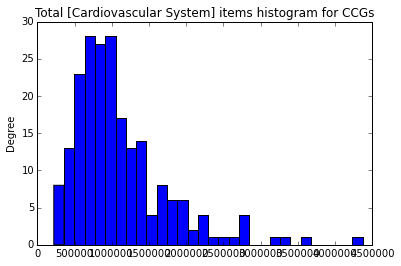

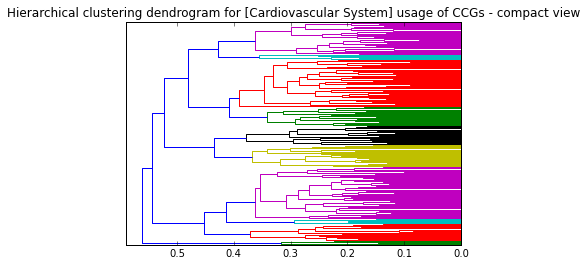

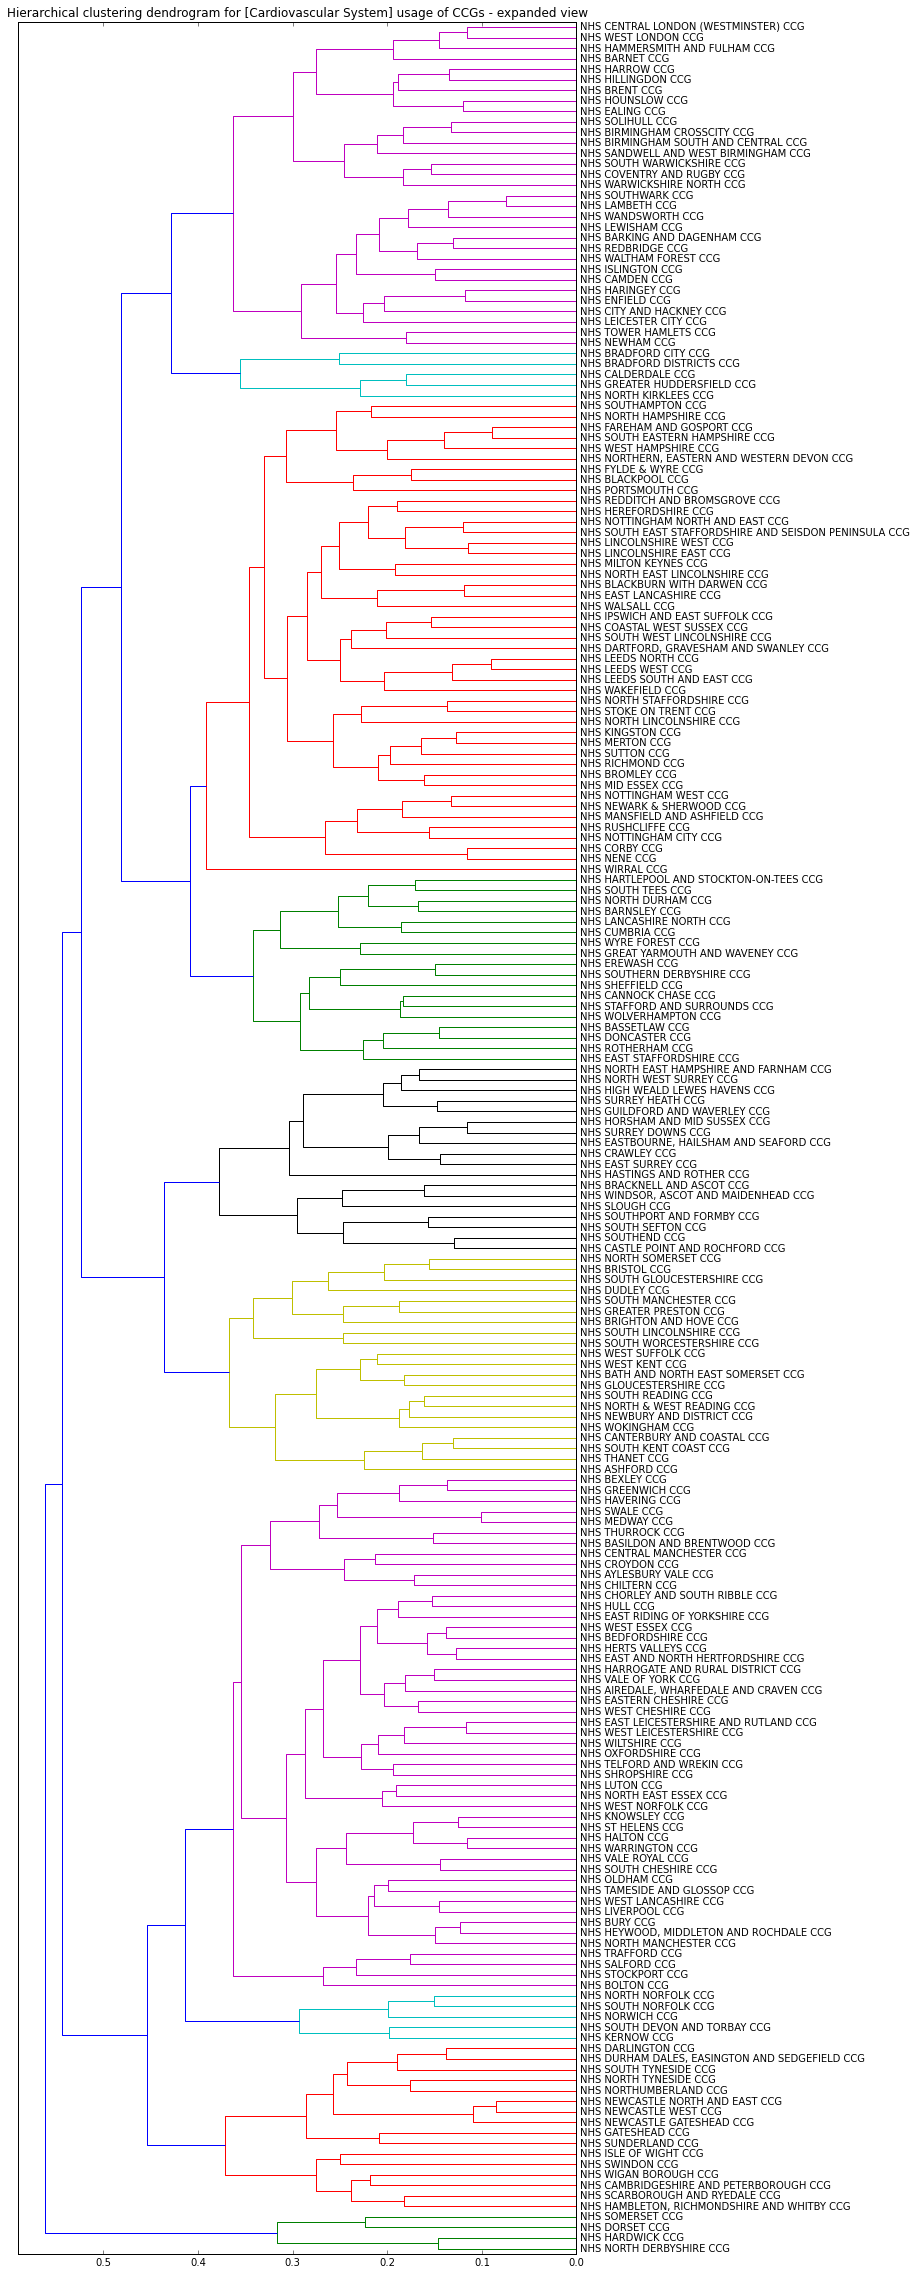

Chapter 03: Respiratory System
Number of products 263


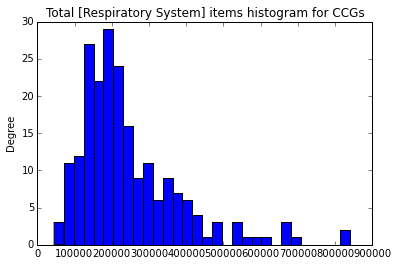

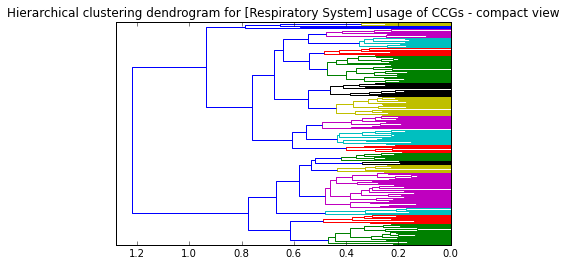

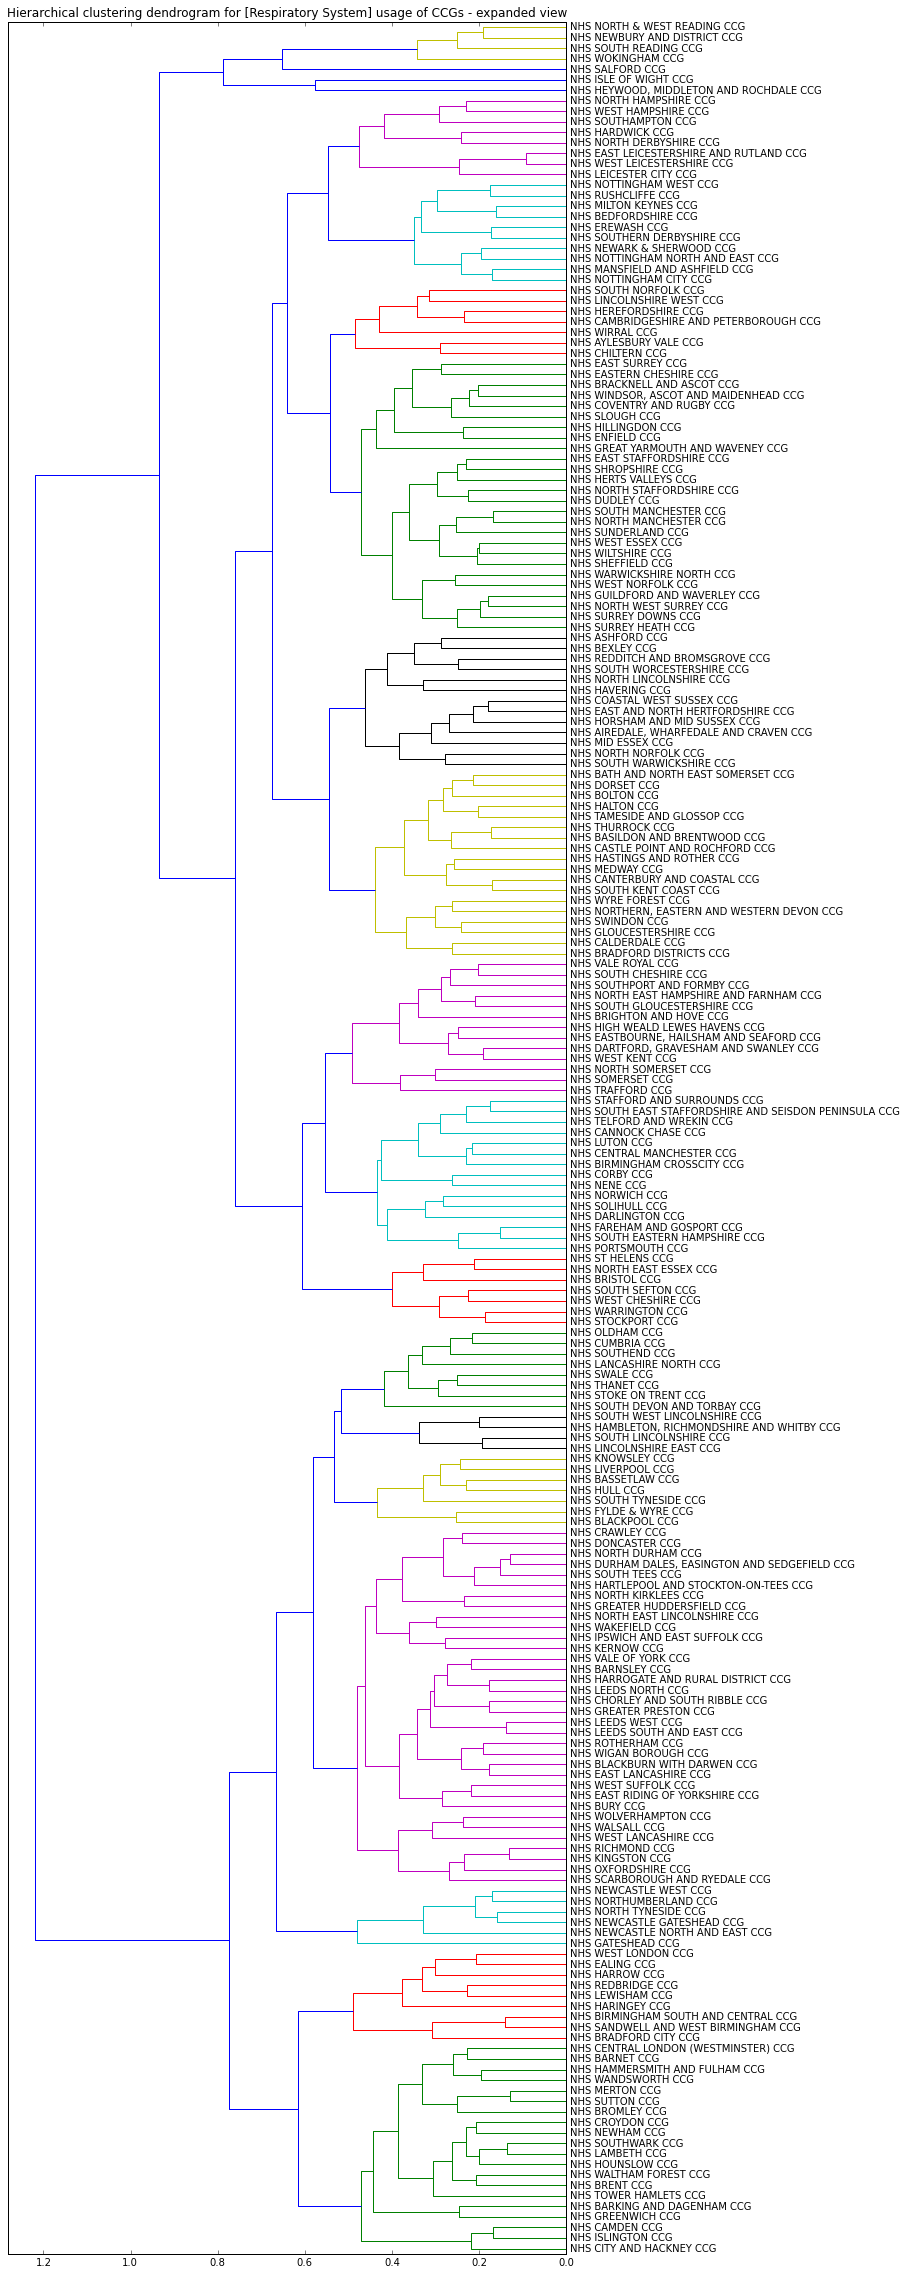

Chapter 04: Central Nervous System
Number of products 674


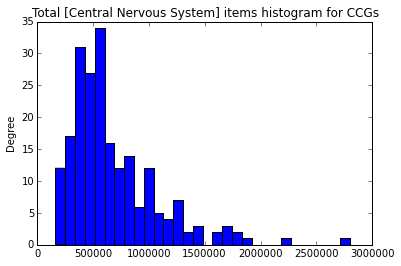

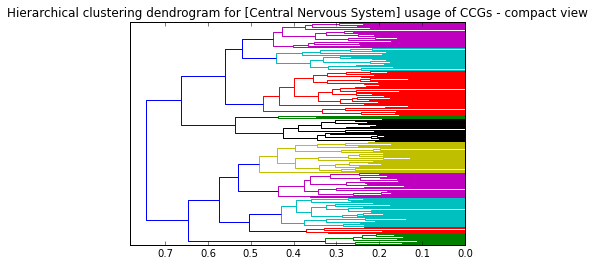

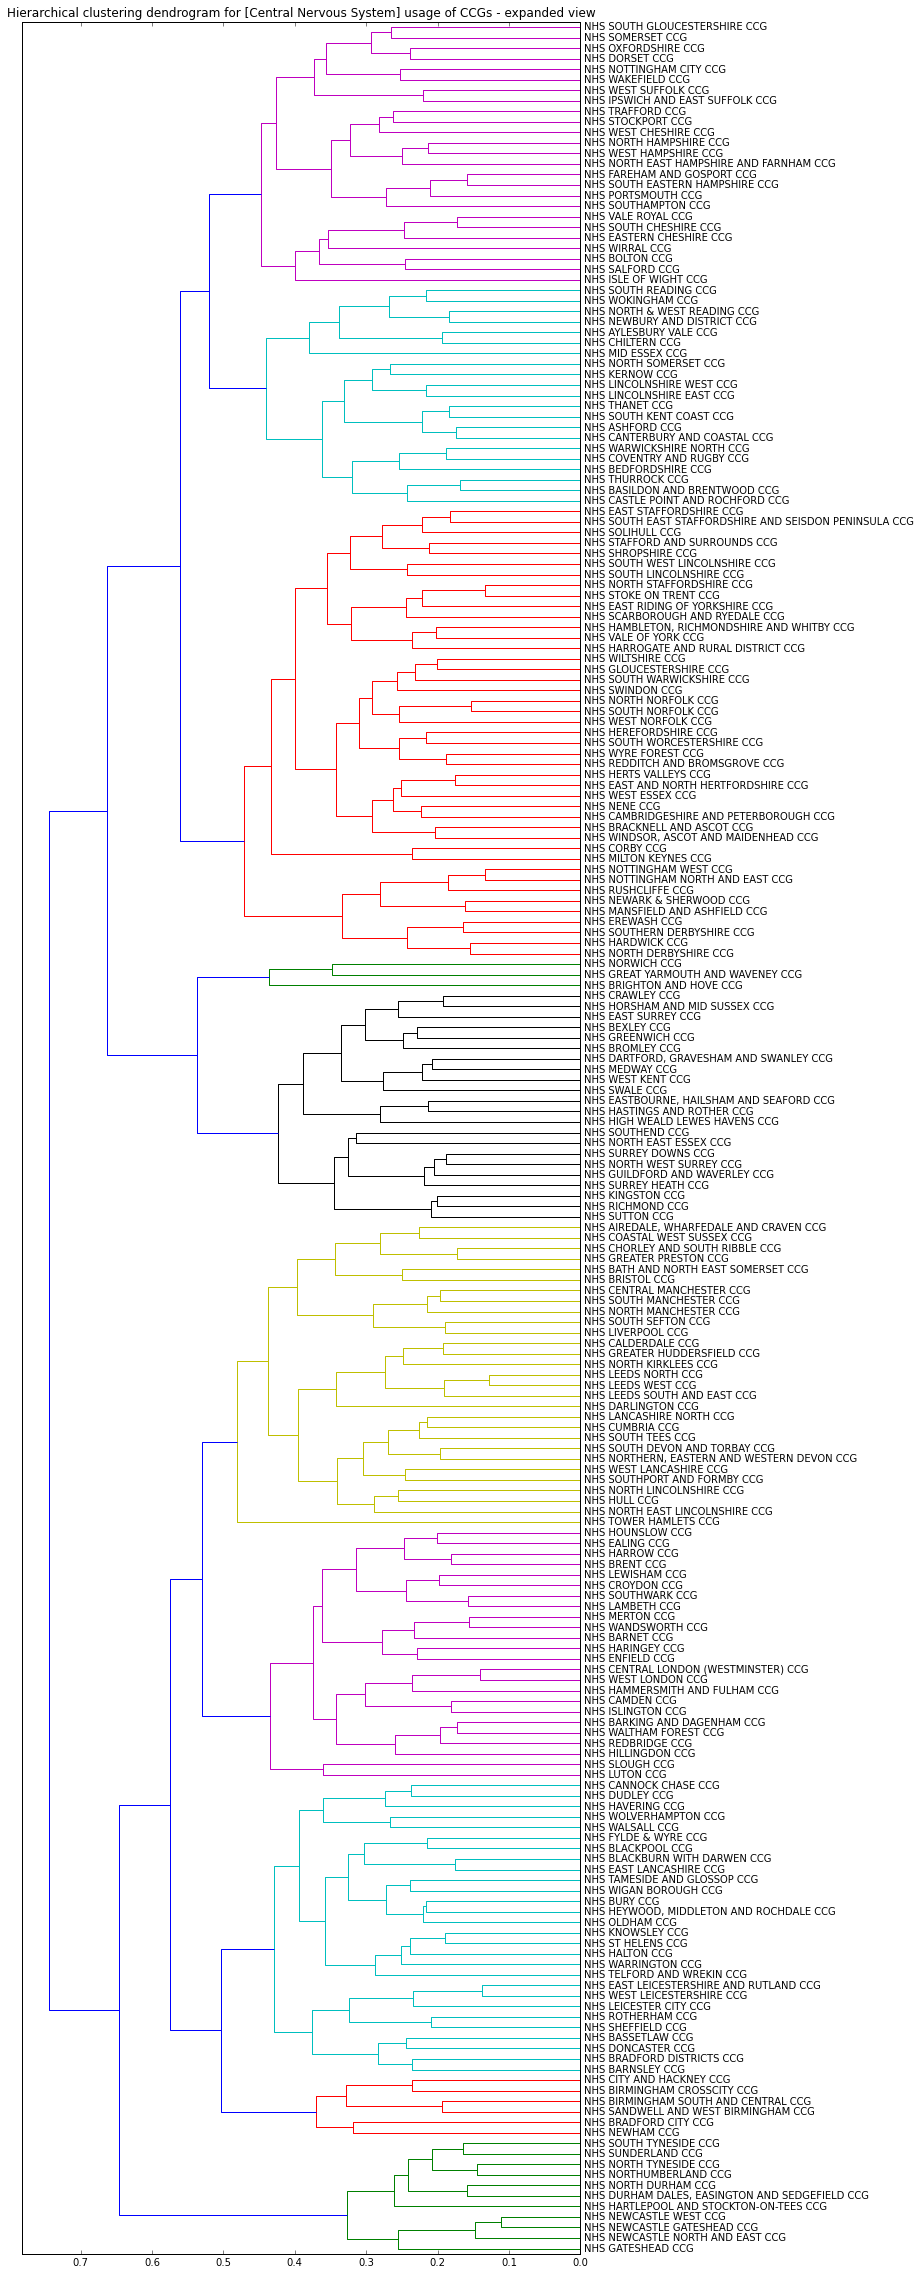

Chapter 05: Infections
Number of products 300


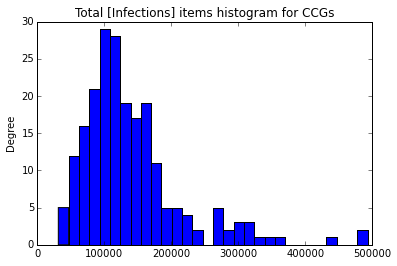

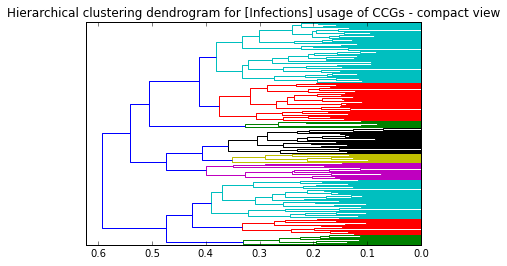

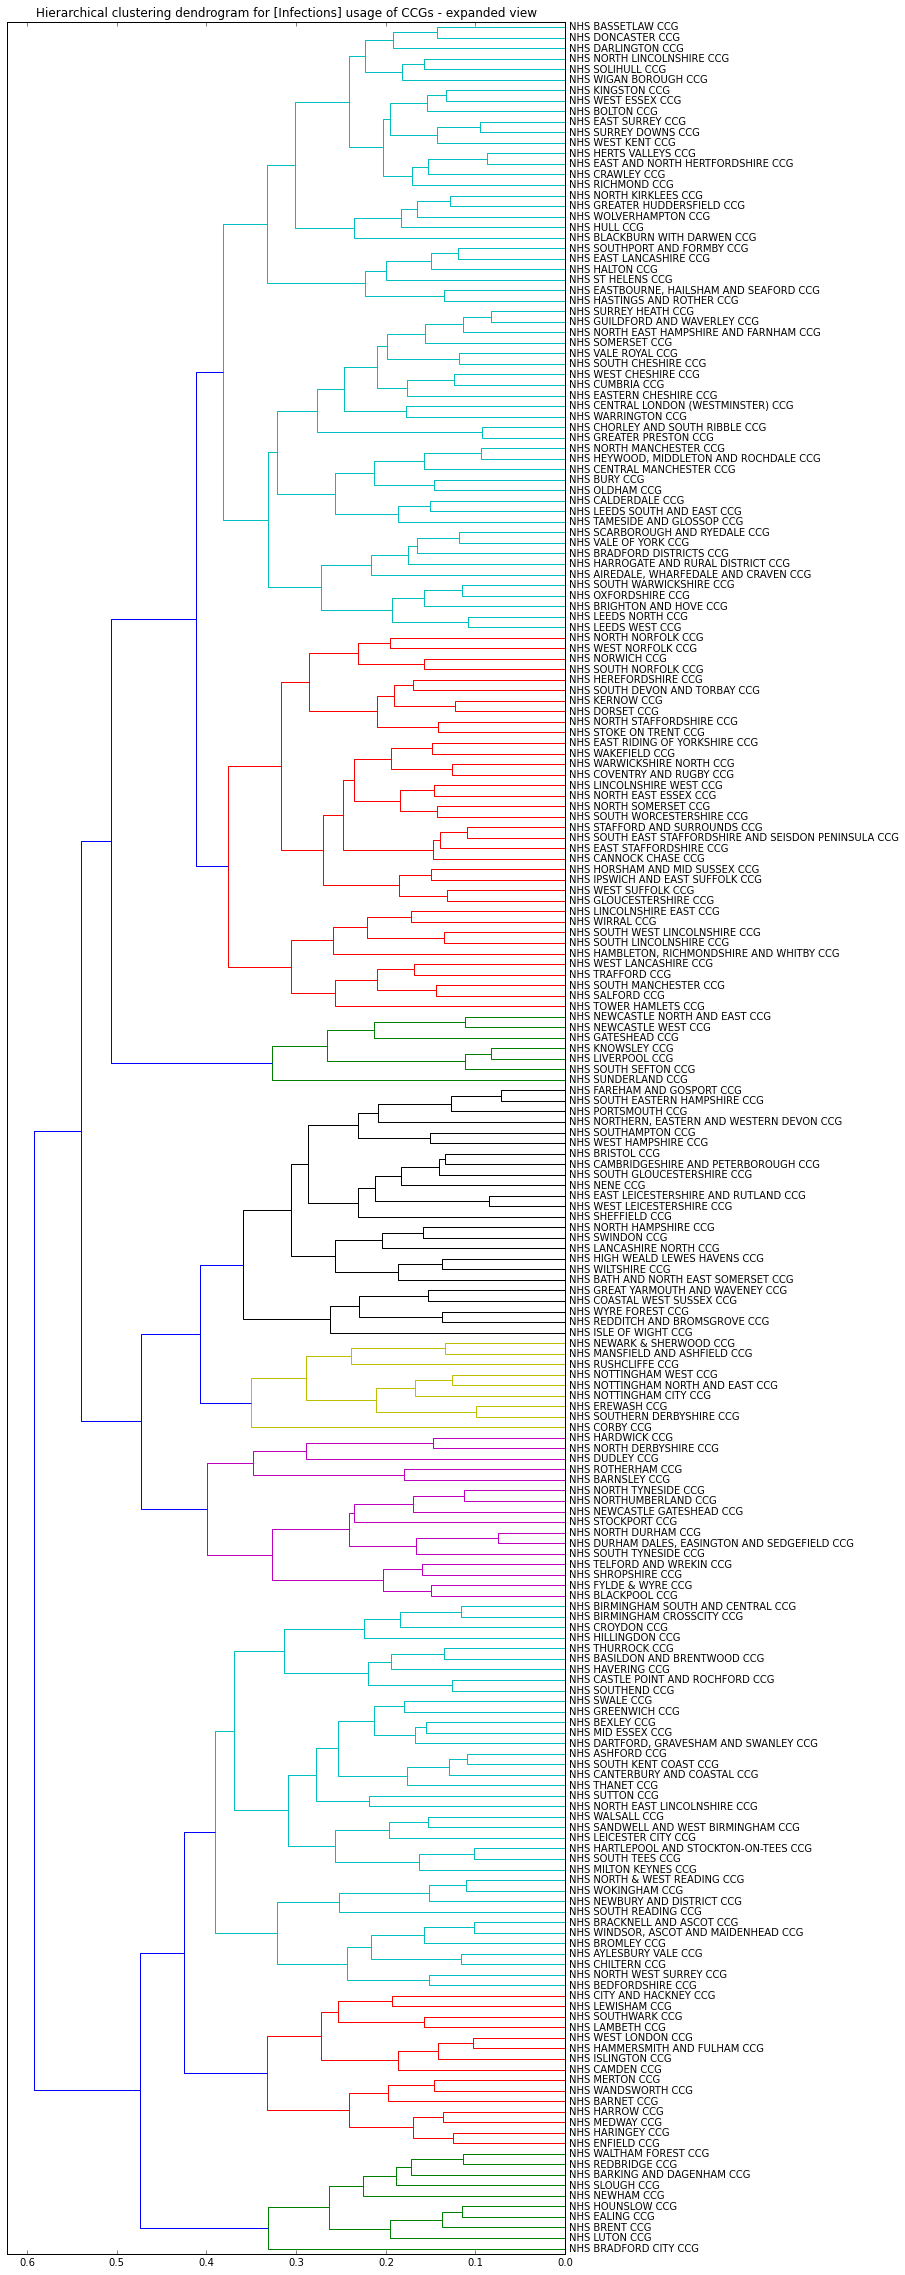

Chapter 06: Endocrine System
Number of products 421


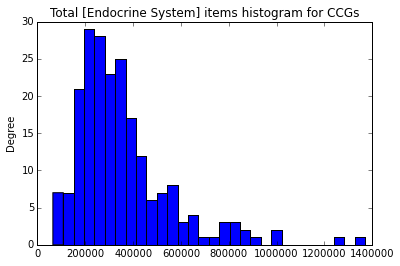

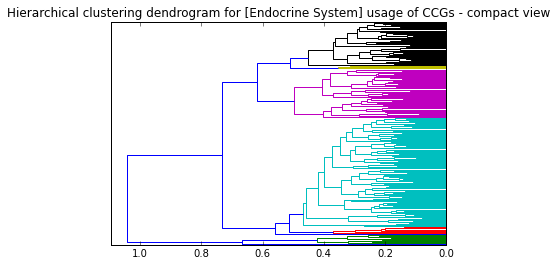

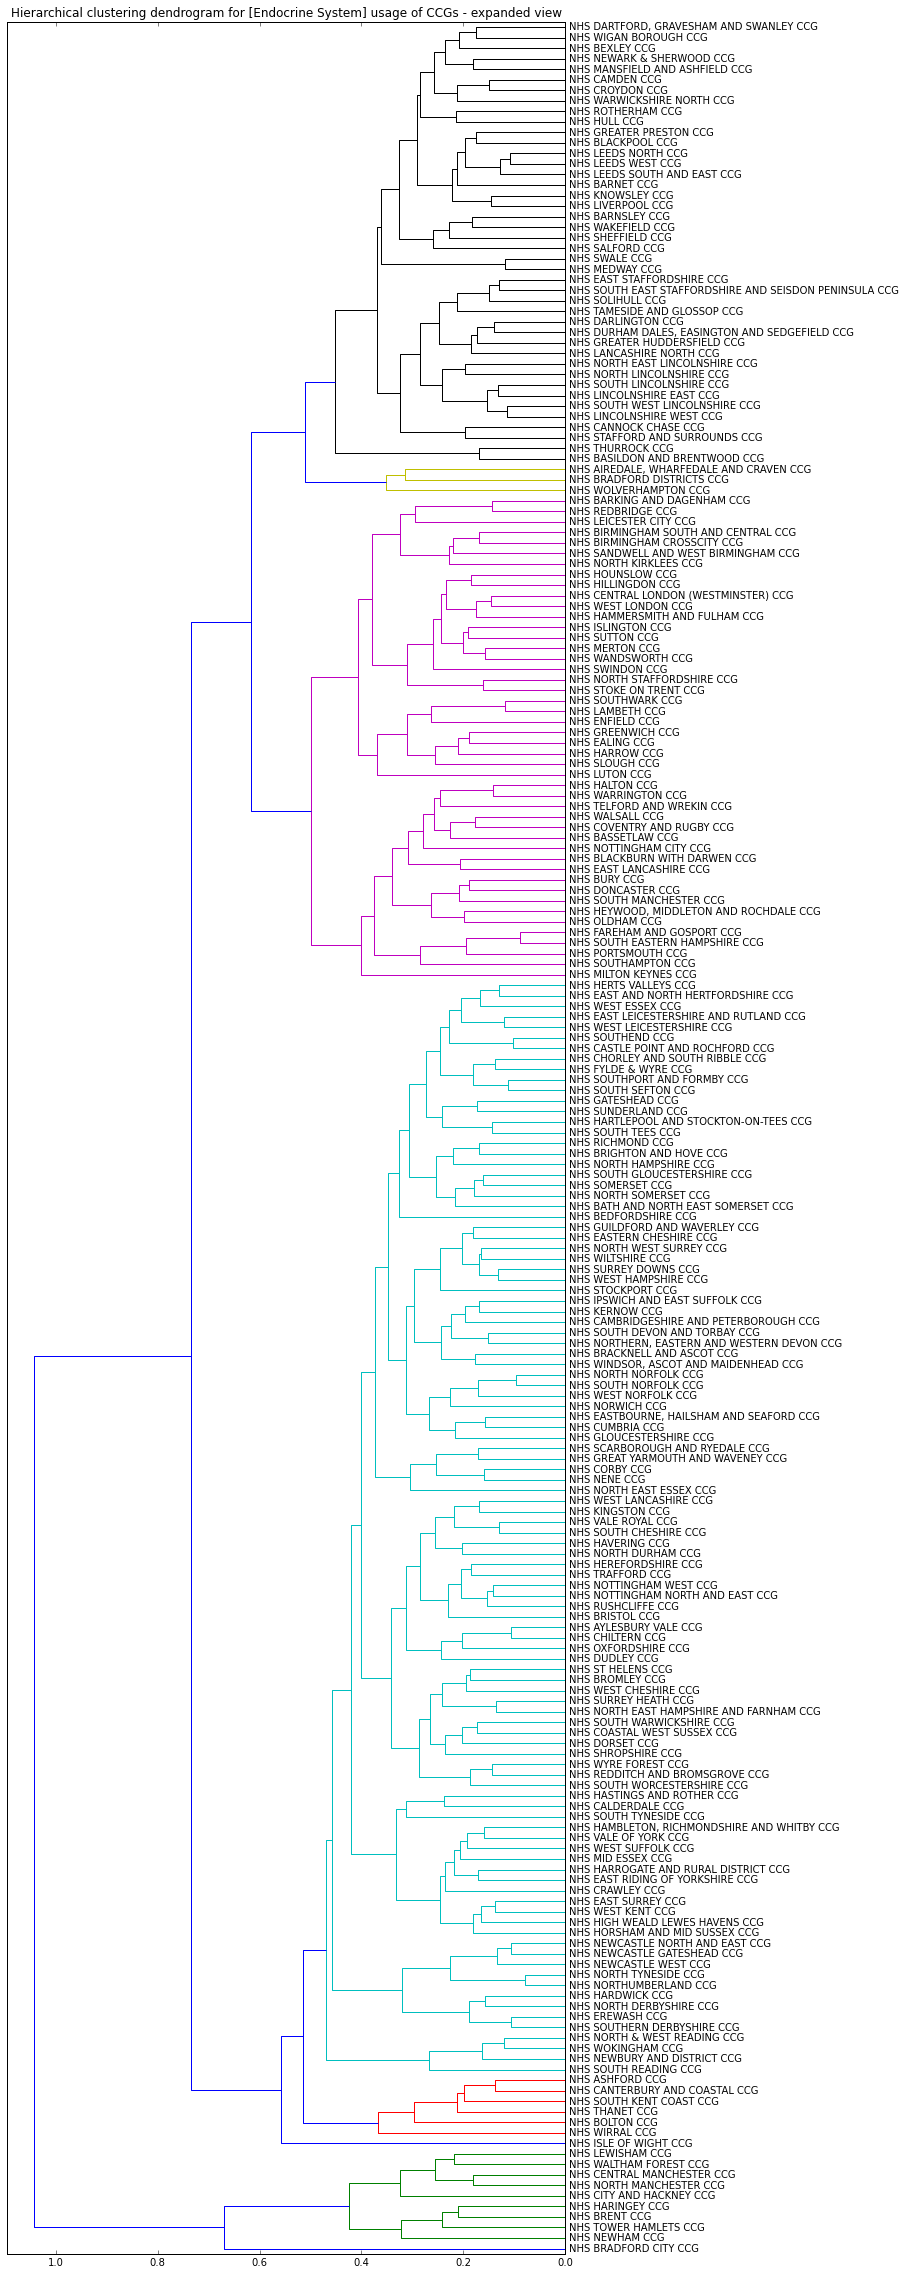

Chapter 07: Obstetrics,Gynae+Urinary Tract Disorders
Number of products 236


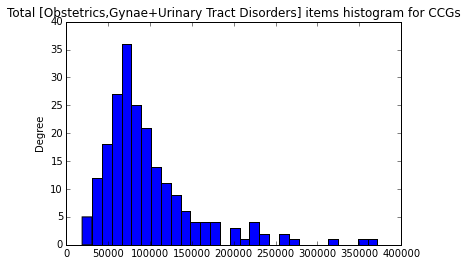

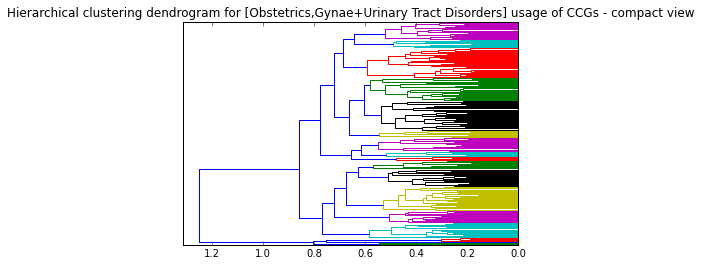

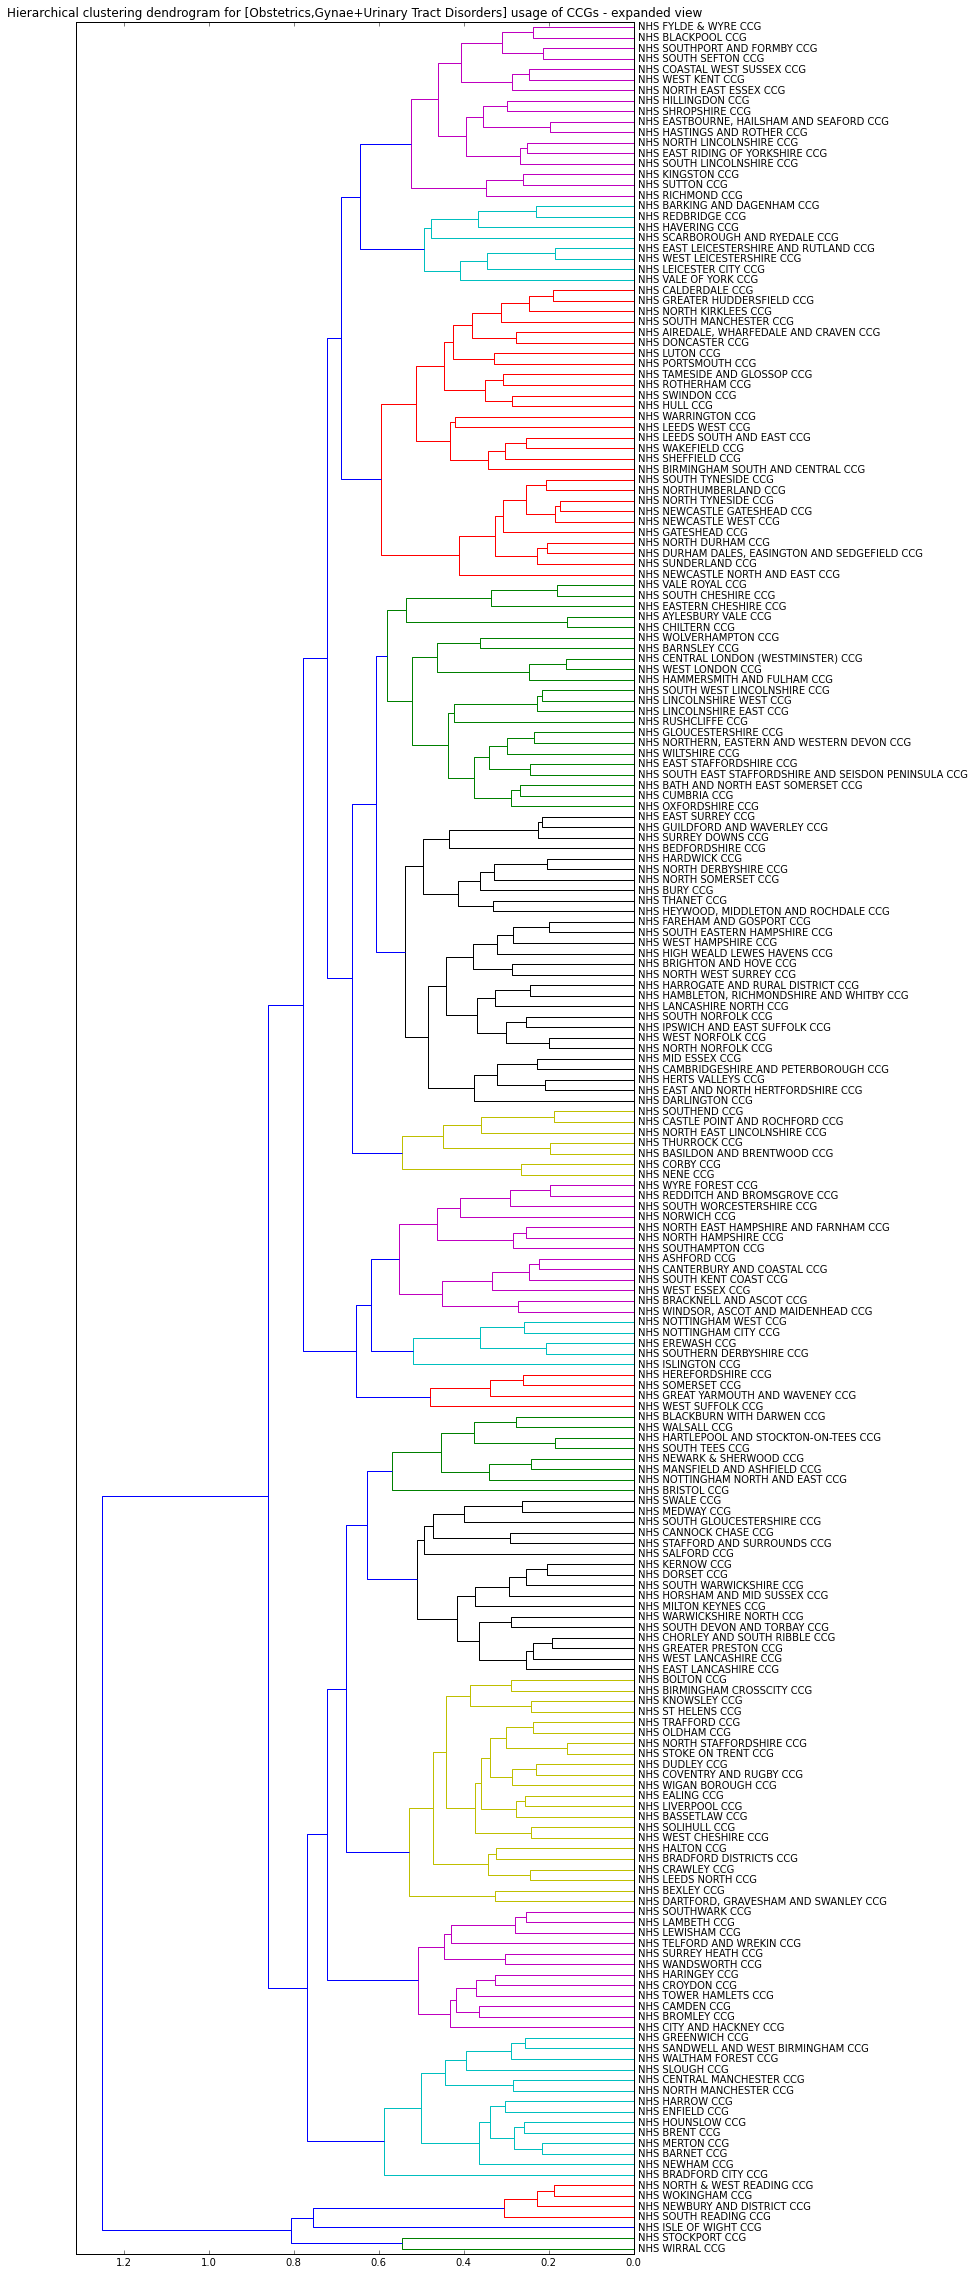

In [67]:
# hand picked!
def color_threshold(chapter):
    return dict(zip(("02","03","04","05","06","07"),(0.4,0.5,0.5,0.4,0.5,0.6)))[chapter]

for chapter in ("02","03","04","05","06","07"):
    desc=bnf.description(chapter)
    print "Chapter %s: %s" % (chapter,desc)
    print "Number of products",len(df.ix[chapter].groupby(level=1).sum().sort(columns=['TOTAL_ITEMS'],ascending=False))
    
    # compute total items per chapter and plot histogram
    ccgs_sum=df.ix[chapter].groupby(level=0).sum().sort(columns=['TOTAL_ITEMS'],ascending=False)
    ccgs_sum['TOTAL_ITEMS'].plot(kind='hist',bins=30,title='Total [%s] items histogram for CCGs' % desc)
    show()
    
    # compute the fraction vectors
    df2=df.ix[chapter].join(ccgs_sum,rsuffix='_SECTION')
    df2['ITEMS_FRAC']=df2['TOTAL_ITEMS']/df2['TOTAL_ITEMS_SECTION']
    ccgs=df2['ITEMS_FRAC'].unstack(1).fillna(0)
    
    # run the clustering:
    Z=linkage(ccgs.as_matrix(),method='complete',metric='cityblock')
    
    # plot it as dendrograms
    plt.figure()
    plt.title('Hierarchical clustering dendrogram for [%s] usage of CCGs - compact view' % desc)
    dendrogram(Z,color_threshold=color_threshold(chapter),orientation='right',
               no_labels=True,
               distance_sort=True,
               #count_sort=True
              )
    
    plt.figure(figsize=(10,40))
    plt.title('Hierarchical clustering dendrogram for [%s] usage of CCGs - expanded view' % desc)
    dendrogram(Z,color_threshold=color_threshold(chapter),orientation='right',
               leaf_label_func=lambda x:ccg.name(ccgs.index[x]),
               distance_sort=True,
               #count_sort=True
              )
    plt.show()
    
    print "=" * 100